# Settings

In [ ]:
use_colab = True

In [ ]:
if use_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Image Processing/Project
  !pip install faiss-gpu
else:
  %cd G:\.shortcut-targets-by-id\1AuC7haUXMGEsPVjb81jUHyIsW7dDnxJy\Project

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/MyDrive/Image Processing/Project'
/content
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.5 MB/s eta 0:00:00


In [ ]:
!pip install torch transformers torchvision

In [ ]:
import os
from pathlib import Path
import pickle
from PIL import Image,ImageFilter
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SequentialSampler
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import pandas as pd
import bisect
import faiss
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt

def show_images(img_list): # img = list(tuple(image, title))
  num_img = len(img_list)
  figsize = num_img * 10

  plt.figure(figsize = (figsize, figsize))

  for i in range(num_img):
    img, title = img_list[i]

    plt.subplot(1,num_img,i+1)
    plt.title(title)
    # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    cmap = None if len(img.shape) == 3 else 'gray'
    img = plt.imshow(img, cmap,interpolation = 'bicubic')

In [ ]:
def img_name_to_path(file_name, ds_loc = 'paris'):
  # landmark = file_name.split('_')[1]
  # return data_path/ds_loc/landmark/f'{file_name}.jpg'
  return data_path / f"{file_name}.jpg"

In [ ]:
transform = transforms.Compose(
        [
            transforms.Resize((224, 224), interpolation = transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
        ])

# Dataset

roxford5k:

https://www.robots.ox.ac.uk/~vgg/data/oxbuildings/oxbuild_images-v1.tgz

rparis6k:

https://www.robots.ox.ac.uk/~vgg/data/parisbuildings/paris_1-v1.tgz

https://www.robots.ox.ac.uk/~vgg/data/parisbuildings/paris_2-v1.tgz

## Annotation

http://cmp.felk.cvut.cz/revisitop/data/datasets/roxford5k/gnd_roxford5k.pkl

http://cmp.felk.cvut.cz/revisitop/data/datasets/rparis6k/gnd_rparis6k.pkl


In [ ]:
data_path = Path('/content/drive/MyDrive/UIT/Nam3/DS102/Doan/Dataset')

data_path

PosixPath('/content/drive/MyDrive/UIT/Nam3/DS102/Doan/Dataset')

In [ ]:
# class RParisDataset(Dataset):
#     def __init__(self, image_root, transform = None):
#         self.image_root = Path(image_root)

#         self.transform = transform

#         with open(data_path/'gnd_rparis6k.pkl', 'rb') as f:
#           self.gnd = pickle.load(f)

#     def __len__(self):
#         return len(self.gnd['imlist'])

#     def __getitem__(self, idx):
#         img_name = self.gnd['imlist'][idx]

#         img_path = img_name_to_path(img_name)

#         _img = Image.open(img_path)
#         _img = _img.convert("RGB")

#         if self.transform:
#           _img = self.transform(_img)

#         return _img, str(img_name)

In [ ]:

class RParisDataset(Dataset):
    def __init__(self, image_root, transform=None):
        self.image_root = Path(image_root)
        self.transform = transform

        # Duyệt qua tất cả các thư mục và lấy tất cả các file hình ảnh
        self.image_files = [f for f in self.image_root.rglob('*') if f.is_file() and f.suffix in ['.jpg', '.jpeg', '.png']]


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]  # Lấy đường dẫn hình ảnh

        _img = Image.open(img_path)
        _img = _img.convert("RGB")

        if self.transform:
            _img = self.transform(_img)
        elements = str(img_path).split('/')[-2:]


        return _img, str('/'.join(elements))  # Trả về hình ảnh và tên file

In [ ]:
# # import os
# # from pathlib import Path
# # from PIL import Image
# # from torch.utils.data import Dataset

# # class RParisCroppedDataset(Dataset):
# #     def __init__(self, image_root, transform=None):
# #         self.image_root = Path(image_root)
# #         self.transform = transform

# #         # Duyệt qua tất cả các thư mục và lấy tất cả các file hình ảnh
# #         self.image_files = [f for f in self.image_root.rglob('*') if f.is_file() and f.suffix in ['.jpg', '.jpeg', '.png']]


# #     def __len__(self):
# #         return len(self.image_files) * 4  # Nhân với 4 để có số lượng các phần cropped

# #     def __getitem__(self, idx):
# #         original_idx = idx // 4  # Tìm chỉ số hình ảnh gốc
# #         partition_idx = idx % 4   # Tìm chỉ số phần cropped
# #         img_name = self.image_files[original_idx].stem + f'_{partition_idx}'  # Lấy tên file mà không có phần mở rộng

# #         img_path = self.image_root / self.image_files[original_idx].name  # Đường dẫn tới hình ảnh

# #         _img = Image.open(img_path)
# #         _img = _img.convert("RGB")

# #         if self.transform:
# #             _img = self.transform(_img)

# #         return _img, str(img_path)  # Trả về hình ảnh và tên file

# import os
# from pathlib import Path
# from PIL import Image
# from torch.utils.data import Dataset

# class RParisCroppedDataset(Dataset):
#     def __init__(self, image_root, transform=None):
#         self.image_root = Path(image_root)
#         self.transform = transform

#         # Find all directories for individual images
#         self.image_files = [f for f in self.image_root.rglob('*') if f.is_file() and f.suffix in ['.jpg', '.jpeg', '.png']]

#     def __len__(self):
#         return len(self.image_files)  # Multiply by 4 for the number of cropped parts

#     def __getitem__(self, idx):
#         # Get the original image index and the partition index
#         # original_idx = idx // 4  # Index of the image directory
#         # partition_idx = idx % 4   # Index of the cropped part

#         # Get the directory for the original image

#         # Construct the path to the specific cropped part
#         # img_path = self.image_files[original_idx] + f'_{partition_idx}' + '.jpg'  # Assuming .jpg extension; adjust if needed
#         # img_path = img_dir / img_name
#         img_path = self.image_files[idx]
#         # Open the cropped image
#         _img = Image.open(img_path)
#         _img = _img.convert("RGB")

#         # Apply any transforms if provided
#         if self.transform:
#             _img = self.transform(_img)
#         elements = str(img_path).split('/')[-2:]

#         return _img, str('/'.join(elements))   # Return the image and the path


**Code thực hiện Partitioning**

In [ ]:
import os
from pathlib import Path
from PIL import Image

def crop_and_save_images_to_folders(image_root, output_root):
  image_root = Path(image_root)
  output_root = Path(output_root)
  output_root.mkdir(parents=True, exist_ok=True)


  # Iterate through all image files in the directory
  for img_path in image_root.rglob('*'):

    if img_path.is_file() and img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
      img = Image.open(img_path).convert("RGB")
      img_width, img_height = img.size

      # Create a folder for each original image
      img_folder = output_root / str(img_path).split('/')[-2]
      img_folder.mkdir(parents=True, exist_ok=True)

      #         # Define crop coordinates for four parts
      crop_coords = [
          (0, 0, img_width // 2, img_height // 2),
          (img_width // 2, 0, img_width, img_height // 2),
          (0, img_height // 2, img_width // 2, img_height),
          (img_width // 2, img_height // 2, img_width, img_height)
      ]

    # Save each cropped part into the folder
      for idx, (left, upper, right, lower) in enumerate(crop_coords):
          cropped_img = img.crop((left, upper, right, lower))
          output_filename = f"{img_path.stem}_{idx}{img_path.suffix}"
          output_path = img_folder / output_filename
          cropped_img.save(output_path)

  print("Partitioning and saving to folders completed!")

# Usage
image_root = "/content/drive/MyDrive/UIT/Nam3/DS102/Doan/Dataset"
output_root = "/content/drive/MyDrive/UIT/Nam3/DS102/Doan/Vietnam-image-cropped"
crop_and_save_images_to_folders(image_root, output_root)



Partitioning and saving to folders completed!


In [ ]:
# def get_query(idx, gnd=par_gnd, transform_query=None):
#     file_name = gnd["qimlist"][idx]
#     img_path = img_name_to_path(file_name)
#     bbx = gnd["gnd"][idx]["bbx"]
#     _img = Image.open(img_path)

#     if transform_query:
#         _img = transform_query(_img)

#     _img = _img.crop(tuple(bbx))
#     _img = _img.convert("RGB")

#     label = {"easy": gnd["gnd"][idx]["easy"], "hard": gnd["gnd"][idx]["hard"]}
#     return _img, label



In [ ]:
# for val in os.listdir(data_path):

par_ds = RParisDataset(data_path, transform)
sampler = SequentialSampler(par_ds)
par_dl = DataLoader(par_ds, batch_size=64, shuffle=False, sampler=sampler)

len(par_ds), len(par_dl)

(2604, 41)

# Model

**Tạo model để trích xuất đặc trưng**

Sử dụng model **Resnet50**

In [ ]:
class FeatureExtractor(torch.nn.Module):
    def __init__(self, device):
        super().__init__()
        self.model = models.resnet50(weights='IMAGENET1K_V2')
        # Get the layers of the model
        self.modules = list(self.model.children())[:-1]
        self.model = nn.Sequential(*self.modules)
        self.model = self.model.eval()
        self.model = self.model.to(device)
        self.shape = 2048 # the length of the feature vector

    def extract_features(self, batch):
        transform = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
        batch = transform(batch)

        # Pass the image through the Resnet50 model and get the feature maps of the input image
        with torch.no_grad():
            feature = self.model(batch)
            feature = torch.flatten(feature, start_dim=1)

        # Return features to numpy array
        return feature.cpu().detach().numpy()

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTModel, ViTFeatureExtractor
import torchvision.transforms as transforms

class FeatureExtractorViT(nn.Module):
    def __init__(self, device):
        super().__init__()
        # Load pre-trained ViT model
        self.model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.model.eval()
        self.model = self.model.to(device)
        self.shape = 768  # Feature vector length for ViT-base model

        # Feature extractor for ViT pre-processing
        self.feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

    def extract_features(self, images):
        # Convert images to the format expected by ViT using the feature extractor
        inputs = self.feature_extractor(images=images, return_tensors="pt").to(next(self.model.parameters()).device)

        # Pass the images through the ViT model and get the [CLS] token embeddings
        with torch.no_grad():
            outputs = self.model(**inputs)
            features = outputs.last_hidden_state[:, 0, :]  # Extract [CLS] token embedding

        # Return features as a numpy array
        return features.cpu().detach().numpy()

In [ ]:
image_path = "/content/dai-noi-hue-1_1624858181.jpg"
image = Image.open(image_path).convert("RGB")

**Sử dụng FAISS để search**

In [ ]:
def create_index(shape, metrics):
    if metrics == "L2":
        index = faiss.IndexFlatL2(shape)
    elif metrics == "IP":
        index = faiss.IndexFlatIP(shape)
    else:
        raise ValueError("metrics must be either L2 or IP")
    return index

In [ ]:
def extract_and_save_features(dl, extractor, index, save_path):
    # Extract features
    with tqdm(total=len(dl), desc="Extracting features") as pbar:
        for images, _ in dl:
            images = images.to(device)
            features = extractor.extract_features(images)
            index.add(features)
            pbar.update(1)

    # Save features
    faiss.write_index(index, save_path)

In [ ]:
feature_root = "./roxford-rparis/embedding"

extractor = FeatureExtractorViT(device)
shape = extractor.shape  # Chiều dài vector đặc trưng
l2_index = create_index(shape, metrics="L2")

extract_and_save_features(par_dl, extractor, l2_index, f"{feature_root}/rparis_resnet50.l2_index.bin")

Extracting features: 100%|██████████| 41/41 [16:09<00:00, 23.64s/it]


**Trích xuất đặc trưng**

Sử dụng model **Resnet50** và Metric là **L2 - Euclidean** để tạo database và search

In [ ]:
feature_root = "./roxford-rparis/embedding"


In [ ]:
extractor = FeatureExtractor(device)
shape = extractor.shape  # Chiều dài vector đặc trưng
l2_index = create_index(shape, metrics="L2")


# Đường dẫn để lưu chỉ mục
feature_root = "./roxford-rparis/embedding"

# Trích xuất và lưu đặc trưng
extract_and_save_features(par_dl, extractor, l2_index, f"{feature_root}/rparis_resnet50.l2_index.bin")



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]
Extracting features: 100%|██████████| 41/41 [14:14<00:00, 20.84s/it]


In [ ]:
#Read index with l2 index
extractor = FeatureExtractorViT(device)
l2_index = faiss.read_index(f"{feature_root}/rparis_resnet50.l2_index.bin")

In [ ]:
def retrieve(query_img, k, index=l2_index):
    img = transform(query_img)
    img = img.unsqueeze(0).to(device)

    feat = extractor.extract_features(img)
    distance, indices = index.search(feat, k)

    return indices[0].tolist(), distance[0].tolist()

In [ ]:
k = 5

query_img = '/content/dai-noi-hue-1_1624858181.jpg'
_img = Image.open(query_img)
_img = _img.convert("RGB")
output = retrieveViT(_img, k, extractor, l2_index)

ValueError: The image to be converted to a PIL image contains values outside the range [0, 1], got [-1.0, 1.0] which cannot be converted to uint8.

In [ ]:
output

([195, 2035, 1500, 1716, 32],
 [0.001108328695409,
  0.0011181588051840663,
  0.0011376254260540009,
  0.0011388561688363552,
  0.0011867875000461936])

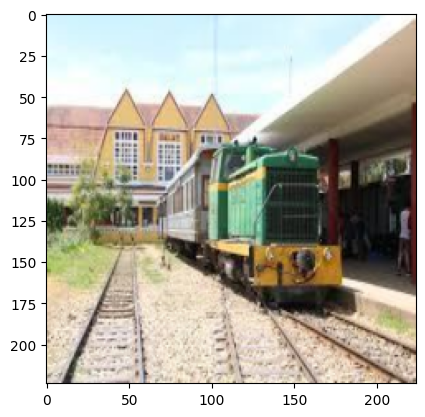

In [ ]:
image_data =  par_ds.__getitem__(1500)[0]
image_data = np.transpose(image_data.numpy(), (1, 2, 0))
plt.imshow(image_data)

# Augment database

In [ ]:
par_cropped_ds = RParisDataset("/content/drive/MyDrive/UIT/Nam3/DS102/Doan/Vietnam-image-cropped", transform=transform)
sampler = SequentialSampler(par_cropped_ds)
par_cropped_dl = DataLoader(par_cropped_ds, batch_size=64, shuffle=False, sampler=sampler)

len(par_cropped_ds), len(par_cropped_dl)

(10416, 163)

**Trích xuất đặc trưng**

In [ ]:
extractor = FeatureExtractor(device)
shape = extractor.shape  # Chiều dài vector đặc trưng
cosine_index = create_index(shape, metrics="IP")


# Đường dẫn để lưu chỉ mục
feature_root = "./roxford-rparis/embedding"

# Trích xuất và lưu đặc trưng
extract_and_save_features(par_cropped_dl, extractor, cosine_index, f"{feature_root}/cropped_rparis_resnet50.l2_index.bin")


Extracting features: 100%|██████████| 163/163 [1:58:53<00:00, 43.76s/it]


In [ ]:
# read features
aug_l2_index = faiss.read_index(f"{feature_root}/cropped_rparis_resnet50.l2_index.bin")

aug_l2_index

<faiss.swigfaiss.IndexFlat; proxy of <Swig Object of type 'faiss::IndexFlat *' at 0x7922513c7930> >

In [ ]:
aug_cosine_index = faiss.read_index(f"{feature_root}/cropped_rparis_resnet50.cosine_index.bin")

RuntimeError: Error in faiss::FileIOReader::FileIOReader(const char*) at /project/faiss/faiss/impl/io.cpp:68: Error: 'f' failed: could not open ./roxford-rparis/embedding/cropped_rparis_resnet50.cosine_index.bin for reading: No such file or directory

In [ ]:
# from tqdm import tqdm

# with tqdm(total=len(par_cropped_dl)) as pbar:
#     for images, paths in par_cropped_dl:
#       images = images.to(device)
#       features = extractor.extract_features(images)
#       aug_index.add(features)
#       pbar.update(1)

# # Save features
# faiss.write_index(aug_index, f'{feature_root}/cropped_rparis_resnet50.index.bin')

In [ ]:
view_ds = RParisDataset(data_path, transform=None)

In [ ]:
view_ds.image_files

[]

In [ ]:
def part_id_to_idx(partition_idx):
  return partition_idx // 4

#aug_index: chỉ xài index nào "cosine" hay "L2"
#src_indices
#src_dst
def extend_answer_on_augment_ds(query_im, k, src_indices, src_dst, aug_index):
    aug_indices, aug_dst = retrieve(query_im, k, index=aug_index)
    for idx, aug_ans in enumerate(aug_indices):
        original_idx = part_id_to_idx(aug_ans)

        if original_idx not in src_indices:
            ins_pos = bisect.bisect_left(src_dst, aug_dst[idx])
            src_indices.insert(ins_pos, original_idx)
            src_dst.insert(ins_pos, aug_dst[idx])

    return src_indices

In [ ]:
extend_answer_on_augment_ds(query_img, 5, )

# Evaluation


## Define metrics

In [ ]:
def AP(pred, ground_truth):
    n_relevance = 0
    n_retrieved = 0
    sum_precision = 0.0

    for item in pred:
        n_retrieved += 1
        if item in ground_truth:
          n_relevance += 1
          sum_precision += (n_relevance/n_retrieved)

    if n_relevance == 0:
      return 0

    return sum_precision / n_relevance

In [ ]:
def expand_answer(src_pred, src_dst, ext_pred, ext_dst):
    for idx, p in enumerate(ext_pred):
        if p not in src_pred:
            ins_pos = bisect.bisect_left(src_dst, ext_dst[idx])
            src_pred.insert(ins_pos, p)
            src_dst.insert(ins_pos, ext_dst[idx])

In [ ]:
max_r = 0

for gnd in par_gnd["gnd"]:
    max_r = max(max_r, len(gnd["easy"]) + len(gnd["hard"]))

max_r

636

In [ ]:
import time

class Scoring:
    def __init__(self):
        self.qlen = len(par_gnd["qimlist"])

        # retrieve and store answers
        self.pred, self.dst, self.gnd_truth = self.retrieve(max_r)


    def retrieve(self, k, query_transform=None):
        pred_list, dst_list, gnd_list = [], [], []
        inf_time = []
        for idx in range(self.qlen):
            src_img, label = get_query(idx=idx, transform_query=query_transform)
            gnd_truth = label["easy"] + label["hard"]

            start = time.time()
            pred, dst = retrieve(src_img, k)
            end = time.time()
            inf_time.append(end-start)
            pred_list.append(pred)
            dst_list.append(dst)
            gnd_list.append(gnd_truth)

        self.mean_inference_time = sum(inf_time) / len(inf_time)
        return pred_list, dst_list, gnd_list

    def map(self, k, pred_list, result_path=None):
        sum_ap = 0
        ap_cache = []
        for i in range(self.qlen):
            pred = pred_list[i][:k]
            gnd = self.gnd_truth[i]

            ap = AP(pred, gnd)
            sum_ap += ap
            ap_cache.append((ap, i))

            if result_path:
                with open(result_path / f"{i}.txt", "w") as f:
                    f.write("\t".join([str(e) for e in pred]))

        return (sum_ap / self.qlen), ap_cache

    def precision_at_k(self, k, pred_list):
        precision_cache = []
        for i in range(self.qlen):
            pred = pred_list[i][:k]
            gnd_truth = self.gnd_truth[i]

            count_relevance = 0

            for ret in pred:
                if ret in gnd_truth:
                    count_relevance += 1
            precision_cache.append(count_relevance / k)

        return sum(precision_cache) / len(precision_cache)

    def precision_at_r(self, pred_list):
        precision_cache = []

        for i in range(self.qlen):
            gnd_len = len(self.gnd_truth[i])
            pred = pred_list[i][:gnd_len]
            gnd_truth = self.gnd_truth[i]

            count_relevance = 0

            for ret in pred:
                if ret in gnd_truth:
                    count_relevance += 1
            precision_cache.append(count_relevance / gnd_len)

        return sum(precision_cache) / len(precision_cache)

    def expand_result(self, k, transform_query=None, iter=1):
        pred = self.pred.copy()
        dst = self.dst.copy()

        for i in range(self.qlen):
            if transform_query is not None:
                for _ in range(iter):
                    ext_img, _ = get_query(idx=i, transform_query=transform_query)
                    ext_pred, ext_dst = retrieve(ext_img, k=k)

                    expand_answer(pred[i], dst[i], ext_pred, ext_dst)

        return pred

    def eval(self, k, pred=None, result_path=None):
        if pred is None:
            pred = self.pred

        map, ap_cache = self.map(k, pred, result_path)
        precision = self.precision_at_k(k, pred)
        r_precision = self.precision_at_r(pred)

        print(
            f"mAP@{k}: {map:.4f}\nPrecision@{k}: {precision:.4f}\nmean R-Precision: {r_precision:.4f}"
        )

        return precision, r_precision, map, ap_cache

## Evaluate by metrics

In [ ]:
scoring = Scoring()

scoring

In [ ]:
# settings
ops = []
k = 50

metrics = {
    f"mAP@{k}": [],
    f"mean Precision@{k}": [],
    "mean R-Precision": [],
}

result_root = data_path / "eval"

In [ ]:
ops.append("ORIGINAL")

print("Scorebroad - ORIGINAL IMAGE")
pres, r_pres, map, ap_cache = scoring.eval(k, result_path=result_root)

metrics[f"mAP@{k}"].append(map)
metrics[f"mean Precision@{k}"].append(pres)
metrics["mean R-Precision"].append(r_pres)

Scorebroad - ORIGINAL IMAGE
mAP@50: 0.9058
Precision@50: 0.8271
mean R-Precision: 0.4857


In [ ]:
ap_cache.sort(key=lambda tup:tup[0])

ap_cache[:10]

[(0.15925925925925927, 69),
 (0.42543918998768326, 68),
 (0.5108299545936837, 67),
 (0.5503940503940504, 56),
 (0.5508110538790876, 59),
 (0.6260388039523188, 63),
 (0.6501066339528639, 62),
 (0.6810341315541201, 50),
 (0.732718134372583, 52),
 (0.7394110670997655, 55)]

# Query expansion

## Closing, opening

In [ ]:
# Image opening
kernel = np.ones((5,5), np.uint8)

def image_opening(img):
  img = np.array(img)
  convert_img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
  img_opening = cv.morphologyEx(convert_img, cv.MORPH_OPEN, kernel)
  img_pil = Image.fromarray(cv.cvtColor(img_opening, cv.COLOR_BGR2RGB))
  return img_pil

def image_closing(img):
  img = np.array(img)
  convert_img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
  img_opening = cv.morphologyEx(convert_img, cv.MORPH_CLOSE, kernel)
  img_pil = Image.fromarray(cv.cvtColor(img_opening, cv.COLOR_BGR2RGB))
  return img_pil

In [ ]:
print("Scorebroad - OPENING OPS")

ops.append("OPENNING")

pred = scoring.expand_result(k, transform_query=image_opening)

pres_k, r_pres, map, ap_cache = scoring.eval(k, pred=pred)

metrics[f"mAP@{k}"].append(map)
metrics[f"mean Precision@{k}"].append(pres_k)
metrics["mean R-Precision"].append(r_pres)

Scorebroad - OPENING OPS
mAP@50: 0.9058
Precision@50: 0.8271
mean R-Precision: 0.4857


In [ ]:
print("Scorebroad - CLOSING OPS")

ops.append("CLOSING")

pred = scoring.expand_result(k, transform_query=image_closing)

pres_k, r_pres, map, ap_cache = scoring.eval(k, pred=pred)

metrics[f"mAP@{k}"].append(map)
metrics[f"mean Precision@{k}"].append(pres_k)
metrics["mean R-Precision"].append(r_pres)

Scorebroad - CLOSING OPS
mAP@50: 0.9058
Precision@50: 0.8266
mean R-Precision: 0.4856


## Random crop

In [ ]:
def random_crop(image):
    image = np.array(image)
    convert_img = cv.cvtColor(image, cv.COLOR_RGB2BGR)

    crop_width = convert_img.shape[1]//2
    crop_height = convert_img.shape[0]//2

    max_x = convert_img.shape[1] - crop_width
    max_y = convert_img.shape[0] - crop_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = convert_img[y: y + crop_height, x: x + crop_width]

    img_pil = Image.fromarray(cv.cvtColor(crop, cv.COLOR_BGR2RGB))

    return img_pil

In [ ]:
print('Scorebroad - RANDOM CROP')

ops.append('RANDOM CROP@5')

pred = scoring.expand_result(k, transform_query=random_crop, iter=5)

pres_k, r_pres, map, ap_cache = scoring.eval(k, pred=pred)

metrics[f"mAP@{k}"].append(map)
metrics[f"mean Precision@{k}"].append(pres_k)
metrics['mean R-Precision'].append(r_pres)

Scorebroad - RANDOM CROP
mAP@50: 0.9059
Precision@50: 0.8257
mean R-Precision: 0.4855


## Random rotation

In [ ]:
def random_rotate(image):
  angle = np.random.randint(low=-30, high=31)
  img_pil = image.rotate(angle)
  return img_pil

In [ ]:
print("Scorebroad - RANDOM ROTATE")
ops.append("RANDOM ROTATE@5")

pred = scoring.expand_result(k, transform_query=random_rotate, iter=5)

pres_k, r_pres, map, ap_cache = scoring.eval(k, pred=pred)

metrics[f"mAP@{k}"].append(map)
metrics[f"mean Precision@{k}"].append(pres_k)
metrics["mean R-Precision"].append(r_pres)

Scorebroad - RANDOM ROTATE


mAP@50: 0.9059
Precision@50: 0.8254
mean R-Precision: 0.4854


## Horizontal flip

In [ ]:
def hor_flip(image):

    img_pil = image.transpose(Image.FLIP_LEFT_RIGHT)

    return img_pil

In [ ]:
print("Scorebroad - HORIZONTAL FLIP")
ops.append("HORIZONTAL FLIP")

pred = scoring.expand_result(k, transform_query=hor_flip)

pres_k, r_pres, map, ap_cache = scoring.eval(k, pred=pred)

metrics[f"mAP@{k}"].append(map)
metrics[f"mean Precision@{k}"].append(pres_k)
metrics["mean R-Precision"].append(r_pres)

Scorebroad - HORIZONTAL FLIP


C:\Users\Hoang\AppData\Local\Temp\ipykernel_13316\3246664538.py:3: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  img_pil = image.transpose(Image.FLIP_LEFT_RIGHT)


mAP@50: 0.9041
Precision@50: 0.8234
mean R-Precision: 0.4857


## Blur, Sharpen and Smooth

In [ ]:
def blur(image):
  return image.filter(ImageFilter.BLUR)

In [ ]:
print("Scorebroad - BLUR")

ops.append("BLUR")

pred = scoring.expand_result(k, transform_query=blur)

pres_k, r_pres, map, ap_cache = scoring.eval(k, pred=pred)

metrics[f"mAP@{k}"].append(map)
metrics[f"mean Precision@{k}"].append(pres_k)
metrics["mean R-Precision"].append(r_pres)

Scorebroad - BLUR
mAP@50: 0.9041
Precision@50: 0.8234
mean R-Precision: 0.4857


In [ ]:
def sharpen(image):
  return image.filter(ImageFilter.SHARPEN)

In [ ]:
print("Scorebroad - SHARPEN")
ops.append("SHARPEN")

pred = scoring.expand_result(k, transform_query=sharpen)

pres_k, r_pres, map, ap_cache = scoring.eval(k, pred=pred)
metrics[f"mAP@{k}"].append(map)
metrics[f"mean Precision@{k}"].append(pres_k)
metrics["mean R-Precision"].append(r_pres)

Scorebroad - SHARPEN
mAP@50: 0.9041
Precision@50: 0.8234
mean R-Precision: 0.4857


In [ ]:
def smooth(image):
  return image.filter(ImageFilter.SMOOTH)

In [ ]:
print("Scorebroad - SMOOTH")

ops.append("SMOOTH")

pred = scoring.expand_result(k, transform_query=smooth)

pres_k, r_pres, map, ap_cache = scoring.eval(k, pred=pred)

metrics[f"mAP@{k}"].append(map)
metrics[f"mean Precision@{k}"].append(pres_k)
metrics["mean R-Precision"].append(r_pres)

Scorebroad - SMOOTH
mAP@50: 0.9041
Precision@50: 0.8234
mean R-Precision: 0.4857


## Edge

In [ ]:
def edge(img):
  img_gray = img.convert("L")
  img_gray = img_gray.filter(ImageFilter.SMOOTH)
  edges = img_gray.filter(ImageFilter.FIND_EDGES)
  return edges

In [ ]:
print("Scorebroad - FIND EDGE")
ops.append("FIND EDGE")

pred = scoring.expand_result(k, transform_query=edge)

pres_k, r_pres, map, ap_cache = scoring.eval(k, pred=pred)

metrics[f"mAP@{k}"].append(map)
metrics[f"mean Precision@{k}"].append(pres_k)
metrics["mean R-Precision"].append(r_pres)

Scorebroad - FIND EDGE
mAP@50: 0.9026
Precision@50: 0.8203
mean R-Precision: 0.4841


# Augmentation

In [ ]:
def recall_by_categories(pred_list):
    recall_orl = []
    recall_hard = []

    for idx in range(len(pred_list)):
        pred = pred_list[idx]
        gnd = par_gnd["gnd"][idx]
        total_easy = len(gnd["easy"])
        total_hard = len(gnd["hard"])
        total = total_easy + total_hard

        recall_orl.append(
            len(set(pred[:total]).intersection(set(gnd["easy"] + gnd['hard']))) / total
        )
        recall_hard.append(
            len(set(pred[:total]).intersection(set(gnd["hard"]))) / total_hard
        )

    recall_orl = np.array(recall_orl)
    recall_hard = np.array(recall_hard)

    return recall_orl.mean(), recall_hard.mean()

In [ ]:
def compute_mrr(pred_list, gnd_list):
  mrr_list = []

  for idx in range(len(pred_list)):
    gnd = gnd_list[idx]
    gnd_size = len(gnd)
    pred = pred_list[idx][:gnd_size]

    for ans_idx, ans in enumerate(pred):
      if ans in gnd:
        mrr_list.append(1/(ans_idx+1))
        break

  mrr_list = np.array(mrr_list)

  return mrr_list.sum() / len(pred_list)

In [ ]:
# recall on original database
src_rc, src_rc_hard = recall_by_categories(scoring.pred)

In [ ]:
ext_pred = scoring.pred.copy()
ext_dst = scoring.dst.copy()

for idx in range(len(ext_pred)):
    image, _ = get_query(idx=idx)
    ext_dst[idx] = extend_answer_on_augment_ds(
        query_im=image,
        k=k * 4,
        src_indices=ext_pred[idx],
        src_dst=ext_dst[idx],
        aug_index=aug_l2_index,
    )

print("Scorebroad - AUGMENTED IMAGE")
ops.append("AUGMENTED DB")

pres_k, r_pres, map, ap_cache = scoring.eval(k, pred=ext_pred)

metrics[f"mAP@{k}"].append(map)
metrics[f"mean Precision@{k}"].append(pres_k)
metrics["mean R-Precision"].append(r_pres)

Scorebroad - AUGMENTED IMAGE
mAP@50: 0.9062
Precision@50: 0.8366
mean R-Precision: 0.5224


In [ ]:
# recall on augmented database
ext_rc, ext_rc_hard = recall_by_categories(ext_pred)

In [ ]:
hard_gnd = []
agg_gnd = []

for label in par_gnd['gnd']:
  hard_gnd.append(label['hard'])
  agg_gnd.append(label['easy'] + label['hard'])

In [ ]:
hard_ext_mrr = compute_mrr(ext_pred, hard_gnd)
ext_mrr = compute_mrr(ext_pred, agg_gnd)

hard_mrr = compute_mrr(scoring.pred, hard_gnd)
mrr = compute_mrr(scoring.pred, agg_gnd)

# Summary

In [ ]:
rows = []
ops = [e.replace(" ", "_") for e in ops]

for key in metrics:
    rows.append([round(m, 4) for m in metrics[key]])

df = pd.DataFrame(rows, columns=ops, index=list(metrics.keys()))

df

,ORIGINAL,OPENNING,CLOSING,RANDOM_CROP@5,RANDOM_ROTATE@5,HORIZONTAL_FLIP,BLUR,SHARPEN,SMOOTH,FIND_EDGE,AUGMENTED_DB
mAP@50,0.9058,0.9058,0.9058,0.9059,0.9059,0.9041,0.9041,0.9041,0.9041,0.9026,0.9062
mean Precision@50,0.8271,0.8271,0.8266,0.8257,0.8254,0.8234,0.8234,0.8234,0.8234,0.8203,0.8366
mean R-Precision,0.4857,0.4857,0.4856,0.4855,0.4854,0.4857,0.4857,0.4857,0.4857,0.4841,0.5224


In [ ]:
df = pd.DataFrame(
    [[src_rc, ext_rc], [src_rc_hard, ext_rc_hard], [mrr, ext_mrr], [hard_mrr, hard_ext_mrr]],
    columns=["Original database", "Augmented database"],
    index=["Recall@Overall", "Recall@Hard", "MRR@Overall", "MRR@Hard"],
)

df.apply(lambda x: round(x, 4))

,Original database,Augmented database
Recall@Overall,0.4841,0.5224
Recall@Hard,0.2928,0.3186
MRR@Overall,0.9786,0.9786
MRR@Hard,0.2034,0.2034


In [ ]:
print(f'Avg inference time: {scoring.mean_inference_time:.2f}s')

Avg inference time: 0.02s
